# 读取音频数据

In [1]:
import numpy as np
import wave
import matplotlib.pyplot as plt

def readfile(path):
    f = wave.open(path, "rb")
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    # nchannels通道数 = 2
    # sampwidth量化位数 = 2
    # framerate采样频率 = 48000 即每采一个点所需时间为1/48000
    # nframes采样点数 = ？
    # 读取nframes个数据，返回字符串格式
    str_data = f.readframes(nframes)
    #将字符串转换为数组，得到一维的short类型的数组
    wave_data = np.fromstring(str_data, dtype=np.short)
    # 整合左声道和右声道的数据
    wave_data = np.reshape(wave_data, [nframes, nchannels]).T
    #取单声道数据进行处理
    wave_data = wave_data[0, :]
    wave_data = wave_data * 1.0 / max(abs(wave_data))
    return wave_data

In [3]:
#读取音频数据
path = r"D:\Jupyter notebook\Dataset\sound\cyy1.wav"
wave_data = readfile(path)
wave_data.shape

D:\anaconda\Lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


(1597200,)

# 时域分析

In [4]:
def Time(wave_data):
    # 通过采样点数和取样频率计算出每个取样的时间
    time = np.arange(0, len(wave_data)) * (1.0 / 48000)
    plt.plot(time, wave_data, c="g")  #取单声道绘制时域图
    plt.xlabel("time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()
    return (wave_data.shape)

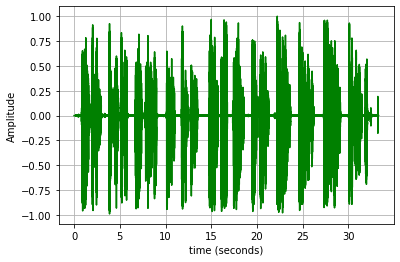

(1597200,)

In [5]:
#绘制时域图
Time(wave_data)

# 双门险端点检测

## 分帧

### 计算帧数

In [6]:
def Nf(wave_data):
    wlen = 3840
    inc = 960  #每帧长度20ms
    signal_length = len(wave_data)  #信号总长度
    if signal_length <= wlen:  #若信号长度小于一个帧的长度，则帧数定义为1
        nf = 1
    else:  #否则，计算帧的总长度
        nf = int(np.ceil((1.0 * signal_length - wlen + inc) / inc))
    return nf

In [7]:
#计算帧数
nf = Nf(wave_data)
print("语音信号被分为{}帧".format(nf))

语音信号被分为1661帧


### 信号分帧

In [8]:
def Frame(wave_data, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    signal_length = len(wave_data)  #信号总长度
    if signal_length <= wlen:  #若信号长度小于一个帧的长度，则帧数定义为1
        nf = 1
    else:  #否则，计算帧的总长度
        nf = int(np.ceil((1.0 * signal_length - wlen + inc) / inc))
    pad_length = int((nf - 1) * inc + wlen)  #所有帧加起来总的铺平后的长度
    zeros = np.zeros(
        (pad_length - signal_length, ))  #不够的长度使用0填补，类似于FFT中的扩充数组操作
    pad_signal = np.concatenate((wave_data, zeros))  #填补后的信号记为pad_signal
    indices = np.tile(np.arange(0, wlen), (nf, 1)) + np.tile(
        np.arange(0, nf * inc, inc),
        (wlen, 1)).T  #相当于对所有帧的时间点进行抽取，得到nf*nw长度的矩阵
    indices = np.array(indices, dtype=np.int32)  #将indices转化为矩阵
    frames = pad_signal[indices]  #得到帧信号
    return frames

In [9]:
#信号分帧
frames = Frame(wave_data, nf)
frames.shape

(1661, 3840)

## 加窗

In [10]:
def Window(frames, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    windown = np.hanning(wlen)
    wf = np.zeros((nf, wlen))  #加窗后数据变为nf*wlen的矩阵
    for i in range(0, nf):
        a = frames[i:i + 1]
        wf[i] = a[0] * windown
    return wf

In [11]:
wf = Window(frames, nf)
wf.shape

(1661, 3840)

## 短时能量

In [12]:
def ShortEnergy(wf, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    energy = np.zeros(nf)
    for i in range(nf):
        c = np.square(wf[i])
        energy[i] = np.sum(c)
    return energy

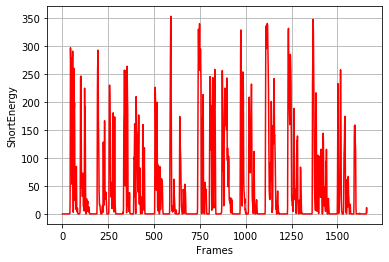

(1661,)

In [13]:
amp = ShortEnergy(wf, nf)
#绘制能量图
nframes = np.arange(len(amp))
plt.figure()
plt.plot(nframes, amp, color='red')
plt.xlabel('Frames')
plt.ylabel('ShortEnergy')
plt.grid()
plt.show()
amp.shape

## 短时过零率

In [14]:
def ZeroCrossingRate(wf, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    counts = np.zeros(nf)
    # rate = np.zeros(nf)
    for i in range(nf):
        a = wf[i]
        for j in range(wlen - 1):
            if a[j] * a[j + 1] < 0:
                counts[i] = counts[i] + 1
        #rate[i] = counts[i]/wlen
    return counts

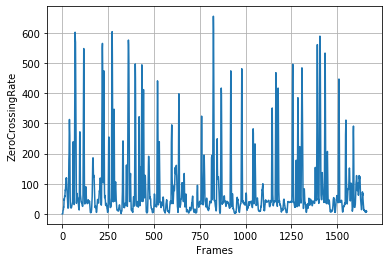

(1661,)

In [15]:
zcr = ZeroCrossingRate(wf, nf)
#绘制过零率图
nframes = np.arange(len(zcr))
plt.figure()
plt.plot(nframes, zcr)
plt.xlabel("Frames")
plt.ylabel("ZeroCrossingRate")
plt.grid()
plt.show()
zcr.shape

## 端点检测

### 参数选择

### 端点检测

In [16]:
def point_check(amp, zcr, Parameters):
    #分配参数
    AmpLow = Parameters[0]  #能量低门限
    AmpHigh = Parameters[1]  #能量高门限
    ZcrLow = Parameters[2]  #过零率低门限
    ZcrHigh = Parameters[3]  #过零率高门限
    MaxSilence = Parameters[4]  #最长间隙时间
    MinAudio = Parameters[5]  #最短语音时间

    #开始端点检测，过渡段语音开始
    StartPoint = 0  #语音起始帧数
    frames = 0  #语音段数
    Start = []  #每段语音起始帧数
    End = []  #每段语音结束帧数
    while StartPoint < len(zcr):
        Status = 0  #状态 0:静音段,1:过渡段,2:语音段,3:结束段,4：音频末段
        HoldTime = 0  #语音持续时间
        SilenceTime = 0  #语音间隙时间
        for i in range(StartPoint, len(zcr)):  #逐帧检测
            if Status == 0 or Status == 1:  #静音段或者过渡段
                if amp[i] > AmpHigh or zcr[
                        i] > ZcrHigh:  #短时能量大于能量高门限或者短时过零率大于过零率高门限
                    StartPoint = i - HoldTime
                    Status = 2  #语音段
                    HoldTime = HoldTime + 1  #语音段继续计数语音持续时间
                    SilenceTime = 0
                elif amp[i] > AmpLow or zcr[
                        i] > ZcrLow:  #短时能量大于能量低门限或者短时过零率大于过零率低门限
                    if i == len(zcr) - 1:  #表明端点检测已结束
                        Status = 4  #音频末段
                    else:
                        Status = 1  #过渡段
                        HoldTime = HoldTime + 1  #过渡段开始计数语音持续时间
                else:
                    if i == len(zcr) - 1:  #表明端点检测已结束
                        Status = 4  #音频末段
                    else:
                        Status = 0  #静音段
                        HoldTime = 0  #静音段不计数语音持续时间
            elif Status == 2:  #语音段
                if amp[i] > AmpLow or zcr[
                        i] > ZcrLow:  #短时能量大于能量低门限或者短时过零率大于过零率低门限
                    HoldTime = HoldTime + 1
                else:  # 静音段
                    SilenceTime = SilenceTime + 1  #可能是另一段语音的开始，即语音间隙时间
                    if SilenceTime < MaxSilence:  #未达到最长语音间隙时间
                        HoldTime = HoldTime + 1
                    elif (HoldTime -
                          SilenceTime) < MinAudio:  #真正语音时间小于最短语音时间，说明可能是噪声
                        Status = 0  #重新开始检测
                        HoldTime = 0
                        SilenceTime = 0
                    else:  #语音间隙时间足够长，说明语音已结束
                        Status = 3  #结束段
            elif Status == 3:
                break
            if Status == 3:
                HoldTime = HoldTime - SilenceTime  #真正的语音持续时间
                EndPoint = StartPoint + HoldTime  #语音结束时间
                Start.append(StartPoint)
                End.append(EndPoint)
                #print("第{0}段语音从第{1}帧开始".format(frames,StartPoint))
                #print("第{0}段语音到第{1}帧结束".format(frames,EndPoint))
                break
            if Status == 4:
                EndPoint = len(zcr)
                Start.append(StartPoint)
                End.append(EndPoint)
                #print("第{0}段语音从第{1}帧开始".format(frames,StartPoint))
                #print("第{0}段语音到第{1}帧结束".format(frames,EndPoint))
                break
        StartPoint = EndPoint + 1
        frames = frames + 1
    return (Start, End, frames)

### 检测区间

In [17]:
def check_signal1(StartPoint, EndPoint, wave_data):
    inc = 960
    startpoint = StartPoint * inc
    endpoint = EndPoint * inc
    wave_data_section = wave_data[startpoint:endpoint]
    return wave_data_section

In [18]:
#设置参数,每个人对应的阈值不同
#分别对应AmpLow,AmpHigh,ZcrLow,ZcrHigh,MaxSilence,MinAudio
Parameters = [1.29, 200, 300, 400, 8, 12]
point = point_check(amp, zcr, Parameters)
print("语音共被分为{}段\n".format(point[2]), end='')
print("\n语音起始帧数{}\n".format(point[0]), end='')
print("\n语音结束帧数{}\n".format(point[1]), end='')
print("\n去掉首尾段结果如下：")

#每段检测的结果（去掉首尾段）
for i in range(1, len(point[0]) - 1):
    print("\n第{0}段语音长度为：{1}，包含帧数为：{2:.0f}帧，起始区间为：[{3},{4}]".format(
        i, len(check_signal1(point[0][i], point[1][i], wave_data)),
        len(check_signal1(point[0][i], point[1][i], wave_data)) / 960,
        point[0][i], point[1][i]))

语音共被分为18段

语音起始帧数[42, 95, 189, 253, 330, 388, 503, 585, 736, 801, 866, 969, 1014, 1106, 1228, 1362, 1499, 1525]

语音结束帧数[83, 144, 234, 289, 368, 446, 545, 617, 779, 836, 926, 1001, 1056, 1175, 1304, 1438, 1524, 1661]

去掉首尾段结果如下：

第1段语音长度为：47040，包含帧数为：49帧，起始区间为：[95,144]

第2段语音长度为：43200，包含帧数为：45帧，起始区间为：[189,234]

第3段语音长度为：34560，包含帧数为：36帧，起始区间为：[253,289]

第4段语音长度为：36480，包含帧数为：38帧，起始区间为：[330,368]

第5段语音长度为：55680，包含帧数为：58帧，起始区间为：[388,446]

第6段语音长度为：40320，包含帧数为：42帧，起始区间为：[503,545]

第7段语音长度为：30720，包含帧数为：32帧，起始区间为：[585,617]

第8段语音长度为：41280，包含帧数为：43帧，起始区间为：[736,779]

第9段语音长度为：33600，包含帧数为：35帧，起始区间为：[801,836]

第10段语音长度为：57600，包含帧数为：60帧，起始区间为：[866,926]

第11段语音长度为：30720，包含帧数为：32帧，起始区间为：[969,1001]

第12段语音长度为：40320，包含帧数为：42帧，起始区间为：[1014,1056]

第13段语音长度为：66240，包含帧数为：69帧，起始区间为：[1106,1175]

第14段语音长度为：72960，包含帧数为：76帧，起始区间为：[1228,1304]

第15段语音长度为：72960，包含帧数为：76帧，起始区间为：[1362,1438]

第16段语音长度为：24000，包含帧数为：25帧，起始区间为：[1499,1524]


### 各区间时域图

In [19]:
def check_signal2(StartPoint, EndPoint, wave_data):
    inc = 960
    startpoint = StartPoint * inc
    endpoint = EndPoint * inc
    wave_data_section = wave_data[startpoint:endpoint]
    time = np.arange(startpoint, endpoint) * (1.0 / 48000)
    plt.plot(time, wave_data_section, c="g")  #取单声道绘制
    plt.xlabel("time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

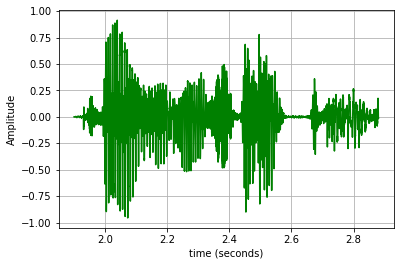

			第1段时域图


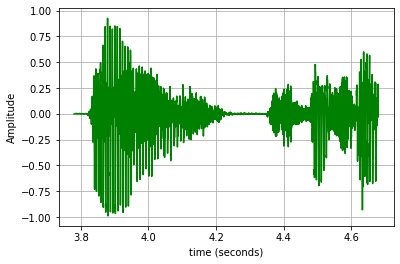

			第2段时域图


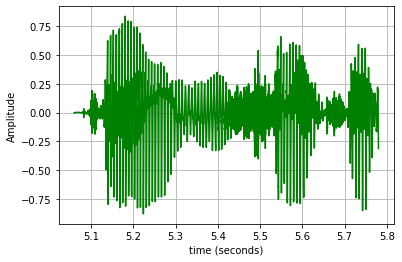

			第3段时域图


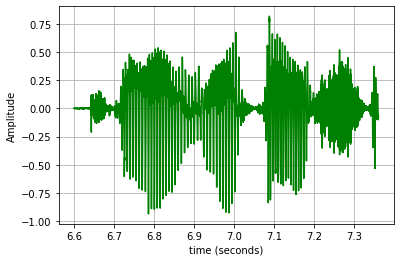

			第4段时域图


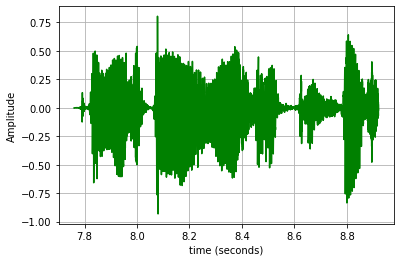

			第5段时域图


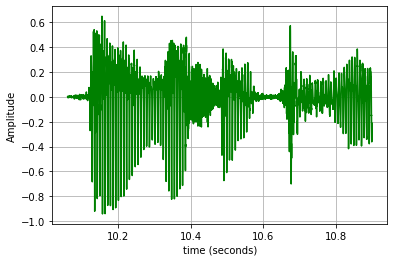

			第6段时域图


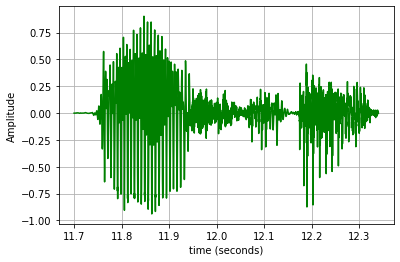

			第7段时域图


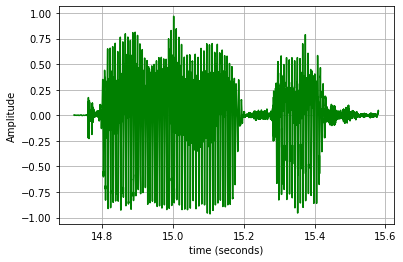

			第8段时域图


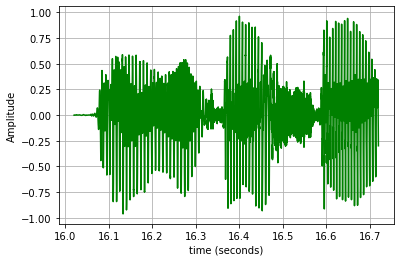

			第9段时域图


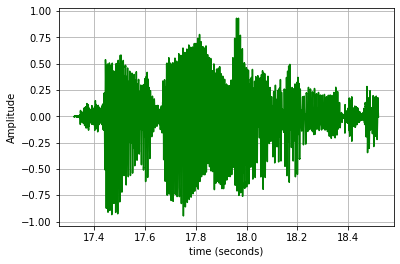

			第10段时域图


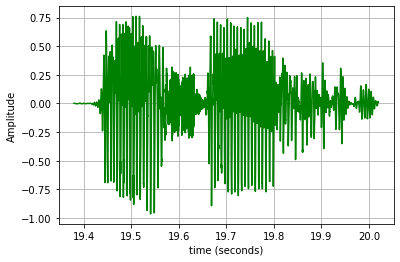

			第11段时域图


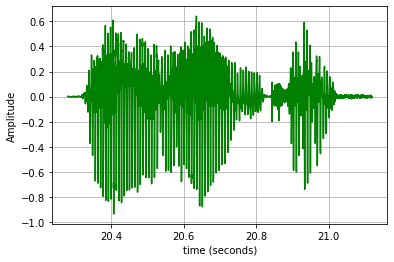

			第12段时域图


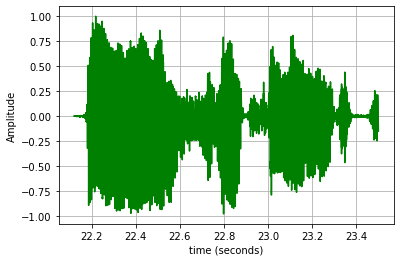

			第13段时域图


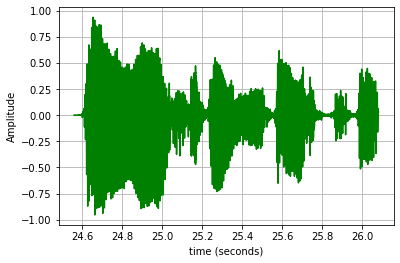

			第14段时域图


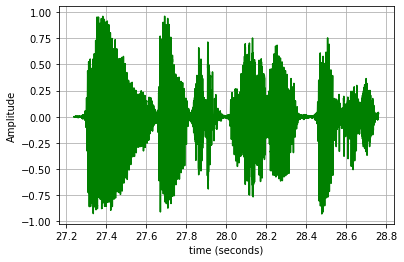

			第15段时域图


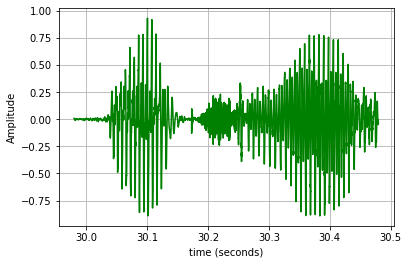

			第16段时域图


In [20]:
#绘制每段的时域图（去掉首位段）
for i in range(1, len(point[0]) - 1):
    check_signal2(point[0][i], point[1][i], wave_data)
    print("\t\t\t第{}段时域图".format(i))

### 信号拼接

In [21]:
#将每段检测的结果进行拼接组成新的语音数据
def joint(point):
    wave_data_ = []
    wave_data__ = []
    for i in range(1, len(point[0]) - 1):
        wave_data_.append(
            list(check_signal1(point[0][i], point[1][i], wave_data)))
    for j in range(1, len(wave_data_) - 1):
        for k in range(len(wave_data_[j])):
            wave_data__.append(wave_data_[j][k])
    return wave_data__

In [22]:
wave_data_new = np.array(joint(point))
wave_data_new.shape

(656640,)

### 函数整合

In [23]:
#将上述所有函数整合成一个函数PointCheck,分帧，加窗，端点检测,信号拼接
def PointCheck(path, Parameters):
    wave_data = readfile(path)  #获取音频数据
    nf = Nf(wave_data)  #获取帧数
    frames = Frame(wave_data, nf)  #分帧
    wf = Window(frames, nf)  #加窗
    amp = ShortEnergy(wf, nf)  #短时能量
    zcr = ZeroCrossingRate(wf, nf)  #短时过零率
    point = point_check(amp, zcr, Parameters)  #端点检测
    wave_data__ = joint(point)  #信号拼接
    return wave_data__

In [24]:
#所有人音频数据
path_fxf = r"D:\Jupyter notebook\Dataset\sound\fxf1.wav"
path_cj = r"D:\Jupyter notebook\Dataset\sound\cj1.wav"
path_cyy = r"D:\Jupyter notebook\Dataset\sound\cyy1.wav"
path_djj = r"D:\Jupyter notebook\Dataset\sound\djj1.wav"
path_lpy = r"D:\Jupyter notebook\Dataset\sound\lpy1.wav"
path_mf = r"D:\Jupyter notebook\Dataset\sound\mf1.wav"
path_op = r"D:\Jupyter notebook\Dataset\sound\op1.wav"
path_sbb = r"D:\Jupyter notebook\Dataset\sound\sbb1.wav"
path_sx = r"D:\Jupyter notebook\Dataset\sound\sx1.wav"
path_xll = r"D:\Jupyter notebook\Dataset\sound\xll1.wav"
path_xmm = r"D:\Jupyter notebook\Dataset\sound\xmm1.wav"

#所有人的端点检测参数
Parameters_fxf = [1.29, 200, 300, 400, 8, 12]
Parameters_cj = [0.09, 11, 300, 400, 8, 12]
Parameters_cyy = [1.29, 200, 300, 400, 8, 12]
Parameters_djj = [1.29, 200, 300, 400, 8, 12]
Parameters_lpy = [0.29, 120, 300, 450, 8, 12]
Parameters_mf = [40, 200, 300, 400, 8, 12]
Parameters_op = [0.69, 30, 300, 400, 8, 12]
Parameters_sbb = [1.29, 190, 300, 400, 8, 12]
Parameters_sx = [1.29, 120, 300, 400, 8, 12]
Parameters_xll = [0.09, 40, 300, 400, 8, 12]
Parameters_xmm = [1.29, 190, 300, 400, 8, 12]

#所有人信号拼接后音频数据
wave_data_fxf1 = np.array(PointCheck(path_fxf, Parameters_fxf))
wave_data_cj1 = np.array(PointCheck(path_cj, Parameters_cj))
wave_data_cyy1 = np.array(PointCheck(path_cyy, Parameters_cyy))
wave_data_djj1 = np.array(PointCheck(path_djj, Parameters_djj))
wave_data_lpy1 = np.array(PointCheck(path_lpy, Parameters_lpy))
wave_data_mf1 = np.array(PointCheck(path_mf, Parameters_mf))
wave_data_op1 = np.array(PointCheck(path_op, Parameters_op))
wave_data_sbb1 = np.array(PointCheck(path_sbb, Parameters_sbb))
wave_data_sx1 = np.array(PointCheck(path_sx, Parameters_sx))
wave_data_xll1 = np.array(PointCheck(path_xll, Parameters_xll))
wave_data_xmm1 = np.array(PointCheck(path_xmm, Parameters_xmm))

D:\anaconda\Lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


# 音频分段

## 将拼接后数据重新分段

In [25]:
#将每个人的音频进行分段
def select_data(wave_data_new):
    length = int(0.2 * 48000)  #0.2s为一段,每段9600个数据
    seg = int(np.ceil(len(wave_data_new) / (length)))  #分成的段数,向上取整
    seg1 = seg - 1  #不包含最后一段，因为有可能包含0
    zeros = np.zeros(length * seg - len(wave_data_new))
    wave_data_new1 = np.concatenate([wave_data_new, zeros
                                     ]).reshape(seg,
                                                length)  #将原数组变成seg*length的数组
    wave_data_new1 = wave_data_new1[:len(wave_data_new1) - 1]
    return (length, seg, seg1, wave_data_new1)

In [26]:
#分段处理后的音频数据
wave_data_fxf = select_data(wave_data_fxf1)[3]
wave_data_cj = select_data(wave_data_cj1)[3]
wave_data_cyy = select_data(wave_data_cyy1)[3]
wave_data_djj = select_data(wave_data_djj1)[3]
wave_data_lpy = select_data(wave_data_lpy1)[3]
wave_data_mf = select_data(wave_data_mf1)[3]
wave_data_op = select_data(wave_data_op1)[3]
wave_data_sbb = select_data(wave_data_sbb1)[3]
wave_data_sx = select_data(wave_data_sx1)[3]
wave_data_xll = select_data(wave_data_xll1)[3]
wave_data_xmm = select_data(wave_data_xmm1)[3]

## 各段时域图

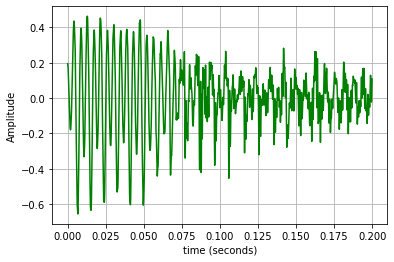

			第1段时域图


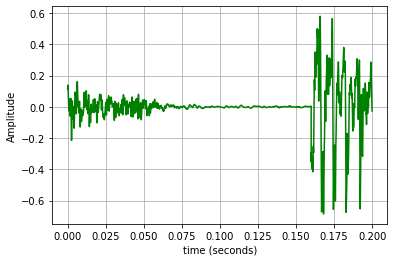

			第2段时域图


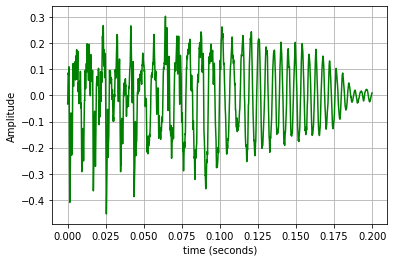

			第3段时域图


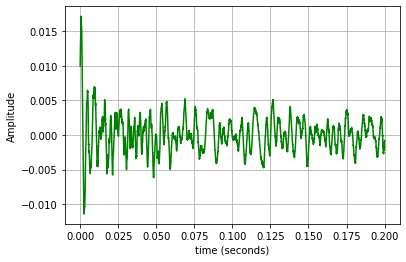

			第4段时域图


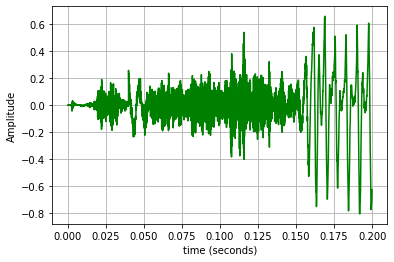

			第5段时域图


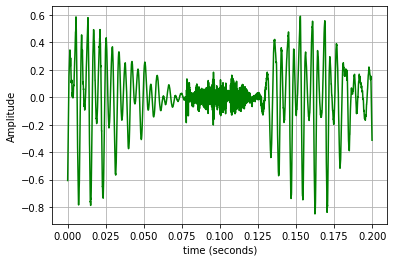

			第6段时域图


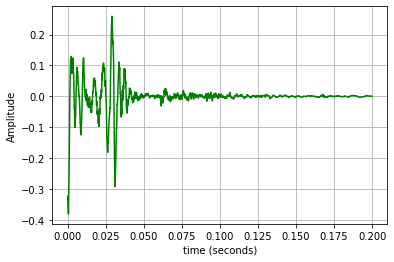

			第7段时域图


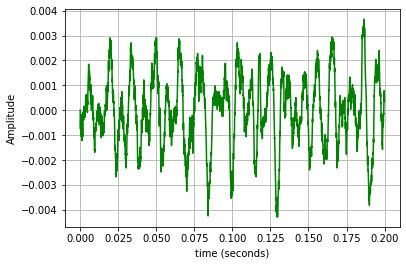

			第8段时域图


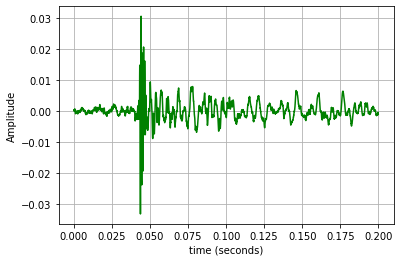

			第9段时域图


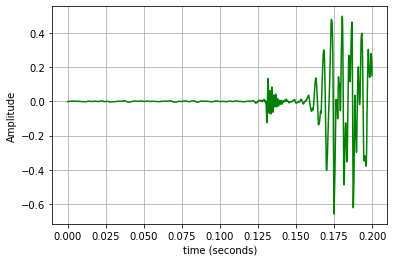

			第10段时域图


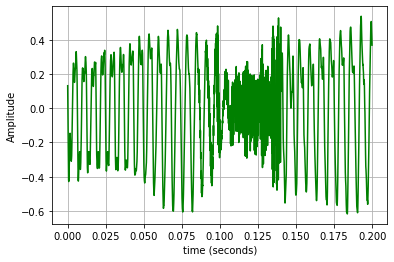

			第11段时域图


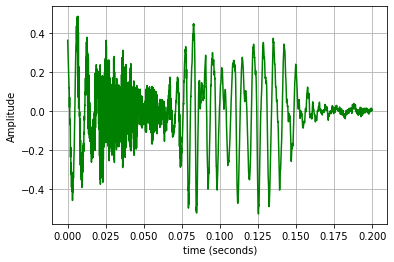

			第12段时域图


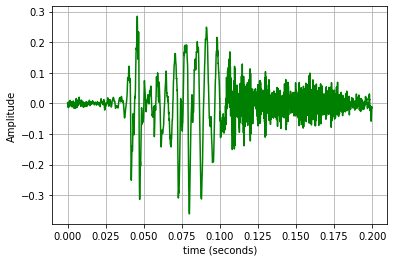

			第13段时域图


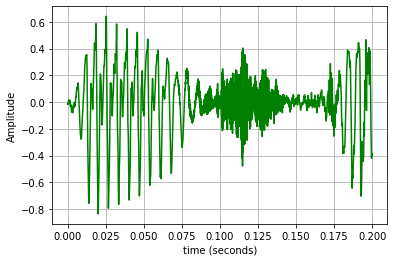

			第14段时域图


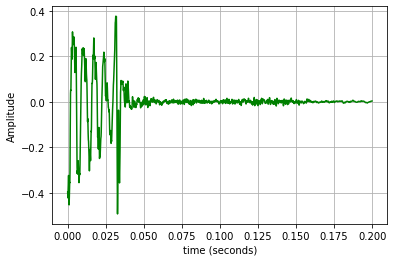

			第15段时域图


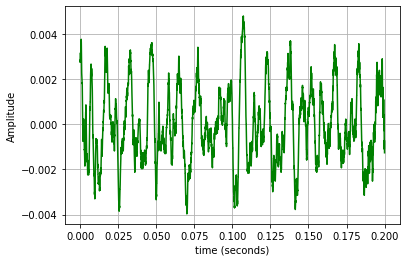

			第16段时域图


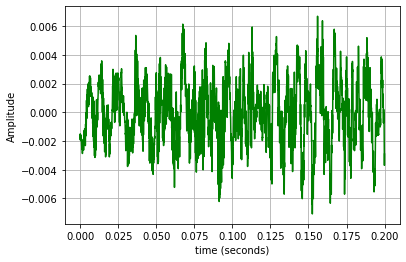

			第17段时域图


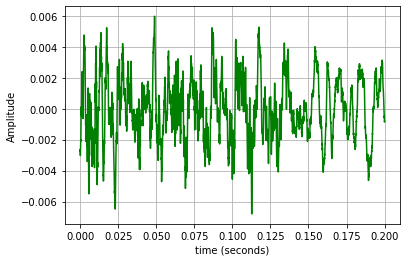

			第18段时域图


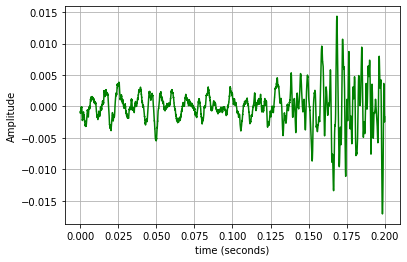

			第19段时域图


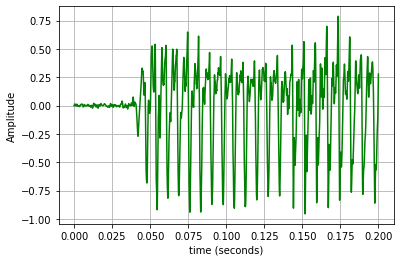

			第20段时域图


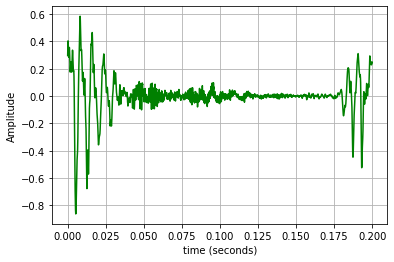

			第21段时域图


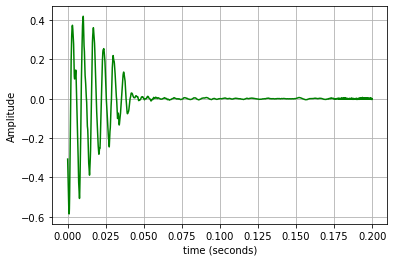

			第22段时域图


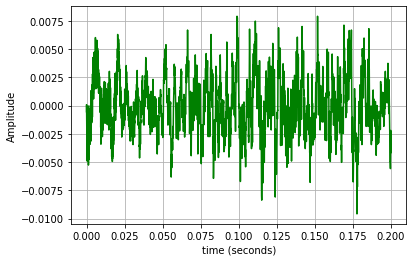

			第23段时域图


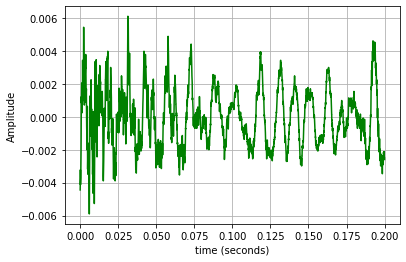

			第24段时域图


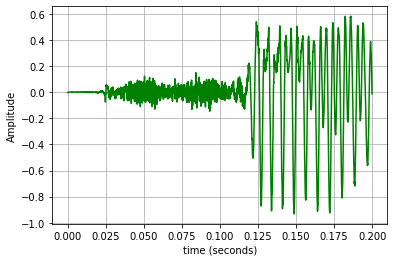

			第25段时域图


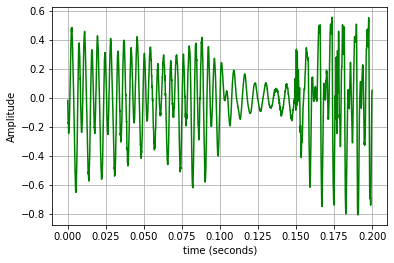

			第26段时域图


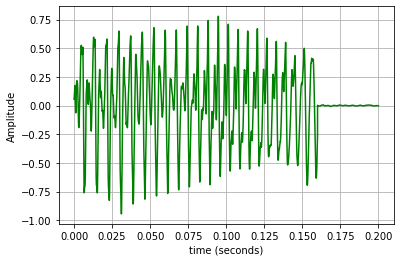

			第27段时域图


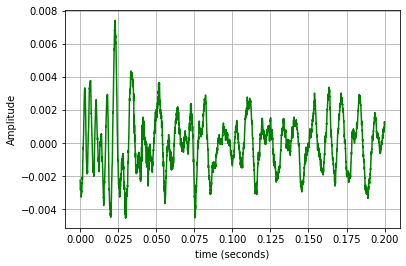

			第28段时域图


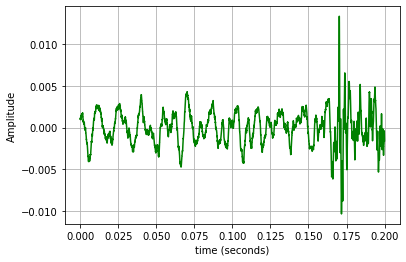

			第29段时域图


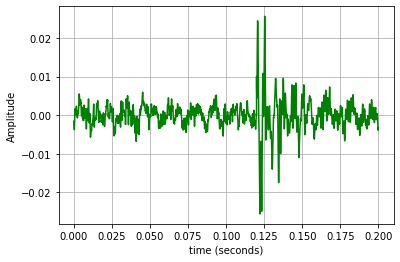

			第30段时域图


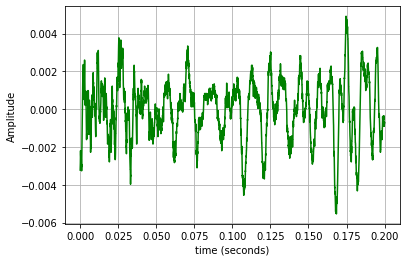

			第31段时域图


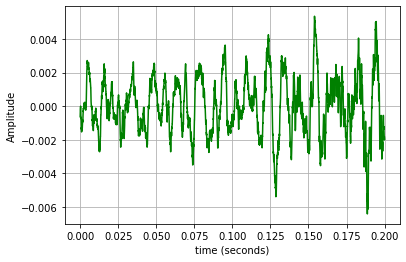

			第32段时域图


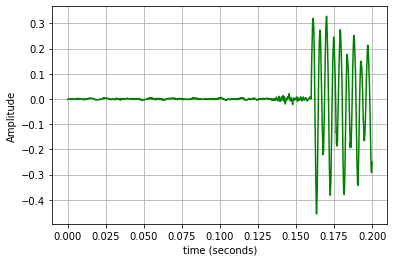

			第33段时域图


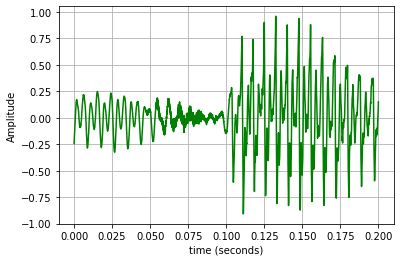

			第34段时域图


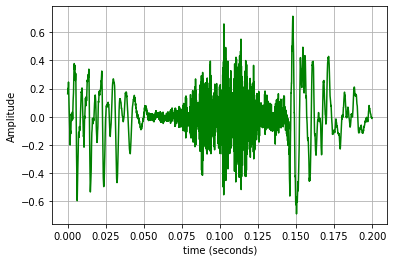

			第35段时域图


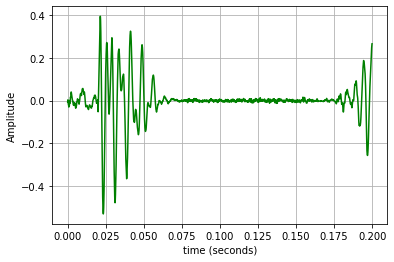

			第36段时域图


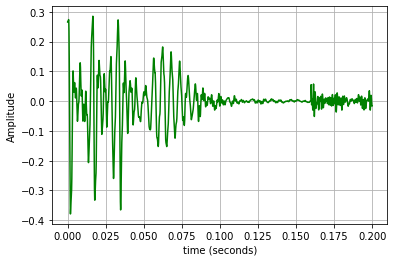

			第37段时域图


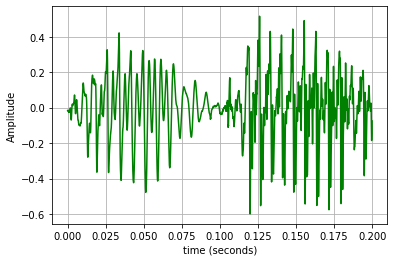

			第38段时域图


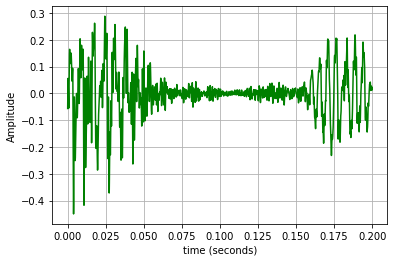

			第39段时域图


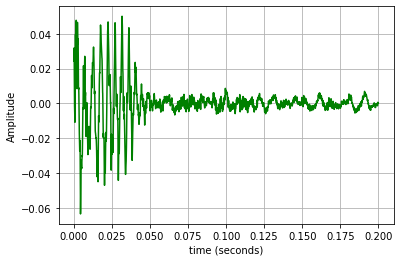

			第40段时域图


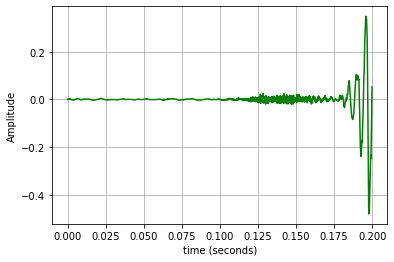

			第41段时域图


In [27]:
#绘制每段的时域图
for i in range(0, len(wave_data_djj)):
    Time(wave_data_djj[i])
    print("\t\t\t第{}段时域图".format(i + 1))

# 频域分析

## 傅里叶变换

In [28]:
def Fourier(wave_data):
    fft_signal = np.fft.fft(wave_data)  # 应用傅里叶变换
    fft_signal = abs(fft_signal)
    fs = int(len(fft_signal) / 2)  #傅里叶变换具有对称性，数据折半处理
    fft_signal = fft_signal[0:fs]
    return (fft_signal)

### fxf频域数据

In [30]:
fft_signal_fxf = []
for i in range(select_data(wave_data_fxf1)[2]):
    fft_signal_fxf.extend(list(Fourier(wave_data_fxf[i])))
fft_signal_fxf = np.array(fft_signal_fxf).reshape(
    select_data(wave_data_fxf1)[2],
    int(select_data(wave_data_fxf1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_fxf.shape

(51, 4800)

### cj频域数据

In [31]:
fft_signal_cj = []
for i in range(select_data(wave_data_cj1)[2]):
    fft_signal_cj.extend(list(Fourier(wave_data_cj[i])))
fft_signal_cj = np.array(fft_signal_cj).reshape(
    select_data(wave_data_cj1)[2],
    int(select_data(wave_data_cj1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_cj.shape

(60, 4800)

### cyy频域数据

In [32]:
fft_signal_cyy = []
for i in range(select_data(wave_data_cyy1)[2]):
    fft_signal_cyy.extend(list(Fourier(wave_data_cyy[i])))
fft_signal_cyy = np.array(fft_signal_cyy).reshape(
    select_data(wave_data_cyy1)[2],
    int(select_data(wave_data_cyy1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_cyy.shape

(68, 4800)

### djj频域数据

In [33]:
fft_signal_djj = []
for i in range(select_data(wave_data_djj1)[2]):
    fft_signal_djj.extend(list(Fourier(wave_data_djj[i])))
fft_signal_djj = np.array(fft_signal_djj).reshape(
    select_data(wave_data_djj1)[2],
    int(select_data(wave_data_djj1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_djj.shape

(41, 4800)

### lpy频域数据

In [34]:
fft_signal_lpy = []
for i in range(select_data(wave_data_lpy1)[2]):
    fft_signal_lpy.extend(list(Fourier(wave_data_lpy[i])))
fft_signal_lpy = np.array(fft_signal_lpy).reshape(
    select_data(wave_data_lpy1)[2],
    int(select_data(wave_data_lpy1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_lpy.shape

(53, 4800)

### mf频域数据

In [35]:
fft_signal_mf = []
for i in range(select_data(wave_data_mf1)[2]):
    fft_signal_mf.extend(list(Fourier(wave_data_mf[i])))
fft_signal_mf = np.array(fft_signal_mf).reshape(
    select_data(wave_data_mf1)[2],
    int(select_data(wave_data_mf1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_mf.shape

(86, 4800)

### op频域数据

In [36]:
fft_signal_op = []
for i in range(select_data(wave_data_op1)[2]):
    fft_signal_op.extend(list(Fourier(wave_data_op[i])))
fft_signal_op = np.array(fft_signal_op).reshape(
    select_data(wave_data_op1)[2],
    int(select_data(wave_data_op1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_op.shape

(79, 4800)

### sbb频域数据

In [37]:
fft_signal_sbb = []
for i in range(select_data(wave_data_sbb1)[2]):
    fft_signal_sbb.extend(list(Fourier(wave_data_sbb[i])))
fft_signal_sbb = np.array(fft_signal_sbb).reshape(
    select_data(wave_data_sbb1)[2],
    int(select_data(wave_data_sbb1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_sbb.shape

(61, 4800)

### sx频域数据

In [38]:
fft_signal_sx = []
for i in range(select_data(wave_data_sx1)[2]):
    fft_signal_sx.extend(list(Fourier(wave_data_sx[i])))
fft_signal_sx = np.array(fft_signal_sx).reshape(
    select_data(wave_data_sx1)[2],
    int(select_data(wave_data_sx1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_sx.shape

(56, 4800)

### xll频域数据

In [39]:
fft_signal_xll = []
for i in range(select_data(wave_data_xll1)[2]):
    fft_signal_xll.extend(list(Fourier(wave_data_xll[i])))
fft_signal_xll = np.array(fft_signal_xll).reshape(
    select_data(wave_data_xll1)[2],
    int(select_data(wave_data_xll1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_xll.shape

(78, 4800)

### xmm频域数据

In [40]:
fft_signal_xmm = []
for i in range(select_data(wave_data_xmm1)[2]):
    fft_signal_xmm.extend(list(Fourier(wave_data_xmm[i])))
fft_signal_xmm = np.array(fft_signal_xmm).reshape(
    select_data(wave_data_xmm1)[2],
    int(select_data(wave_data_xmm1)[0] / 2))  #将傅里叶变换后的数据存入新数组中
fft_signal_xmm.shape

(67, 4800)

## 各段频域图

In [41]:
# 绘制语音信号的频域图
def Freq(fft_signal):
    # 建立时间轴
    Freq = np.arange(int(len(fft_signal)))
    plt.figure()
    plt.plot(Freq, fft_signal, color='blue')
    plt.xlabel('Freq(Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()
    return (fft_signal.shape)

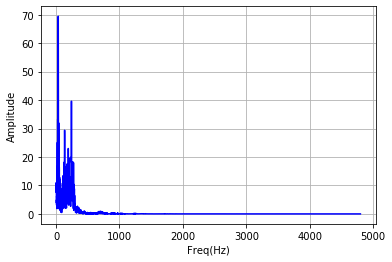

			第1段频域图


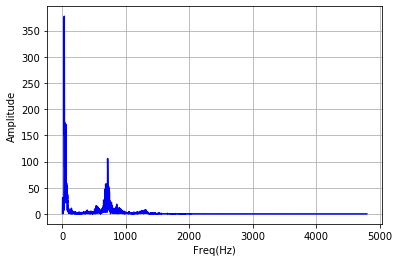

			第2段频域图


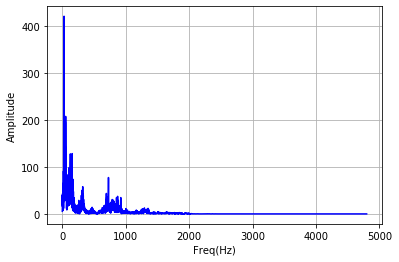

			第3段频域图


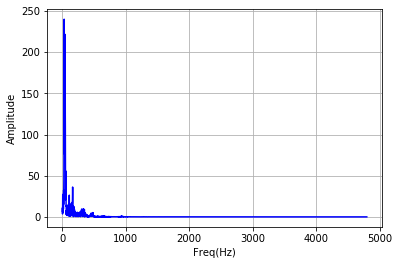

			第4段频域图


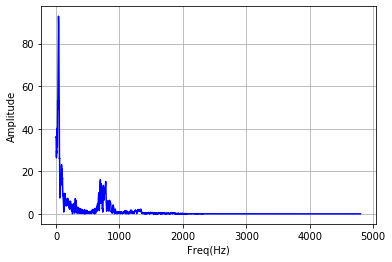

			第5段频域图


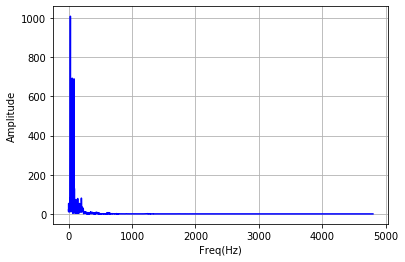

			第6段频域图


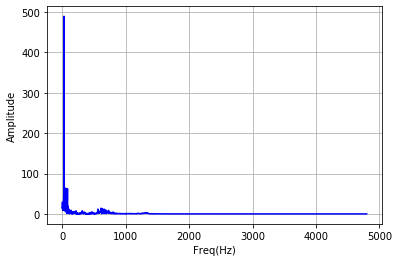

			第7段频域图


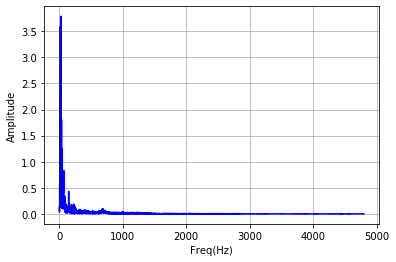

			第8段频域图


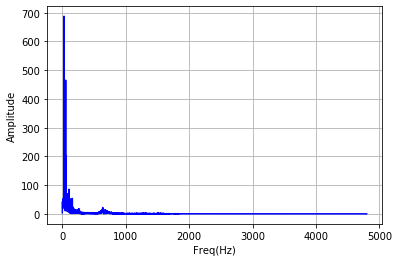

			第9段频域图


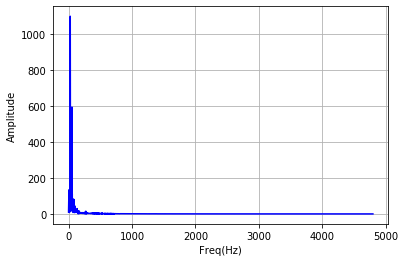

			第10段频域图


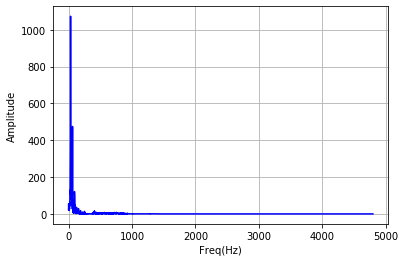

			第11段频域图


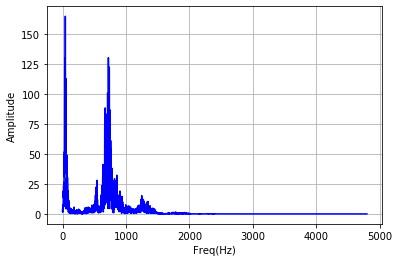

			第12段频域图


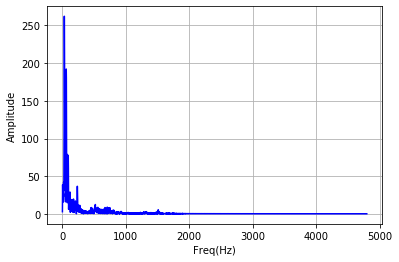

			第13段频域图


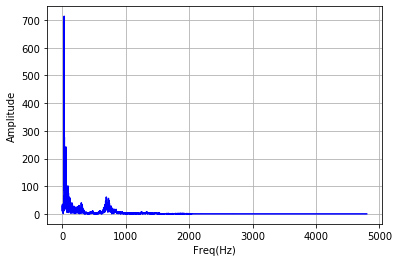

			第14段频域图


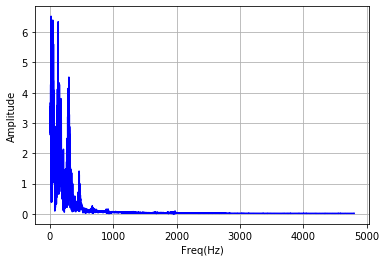

			第15段频域图


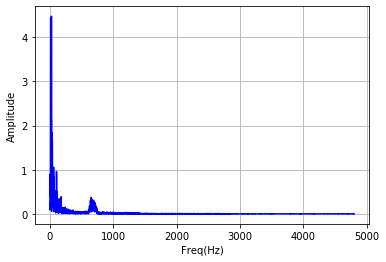

			第16段频域图


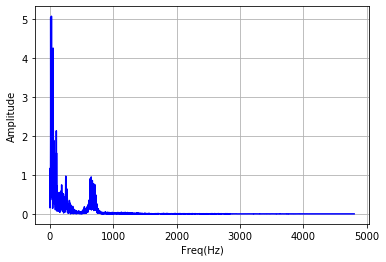

			第17段频域图


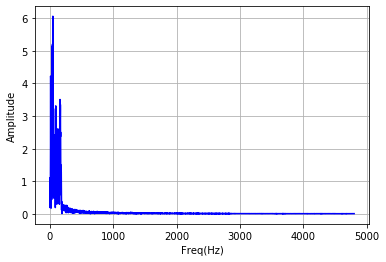

			第18段频域图


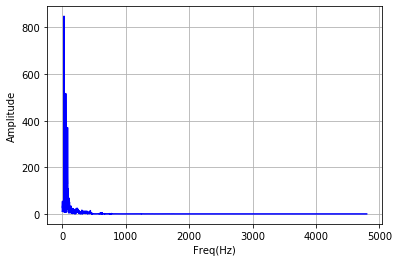

			第19段频域图


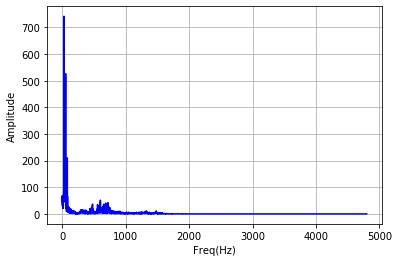

			第20段频域图


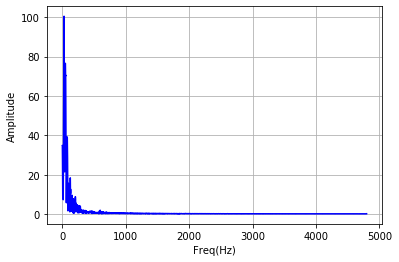

			第21段频域图


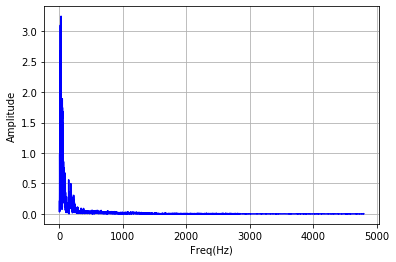

			第22段频域图


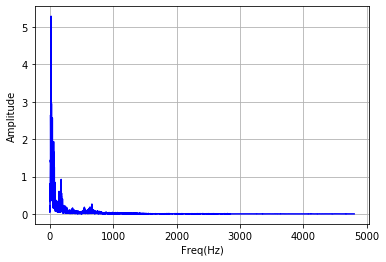

			第23段频域图


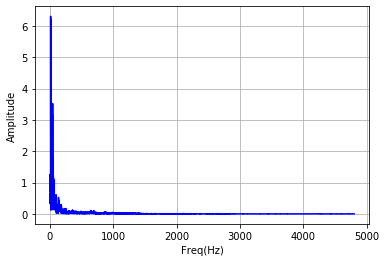

			第24段频域图


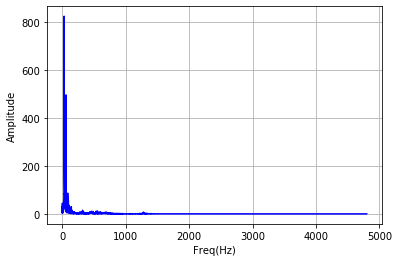

			第25段频域图


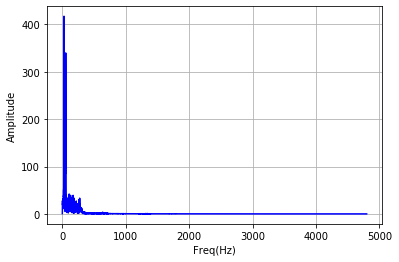

			第26段频域图


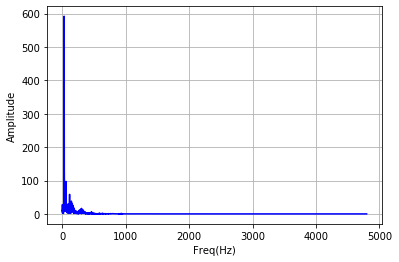

			第27段频域图


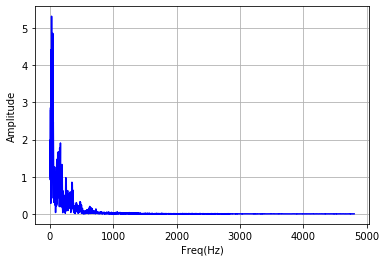

			第28段频域图


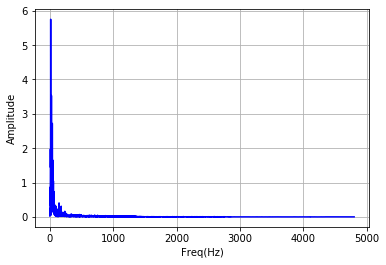

			第29段频域图


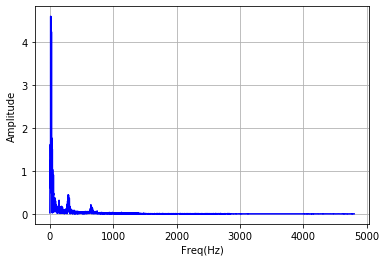

			第30段频域图


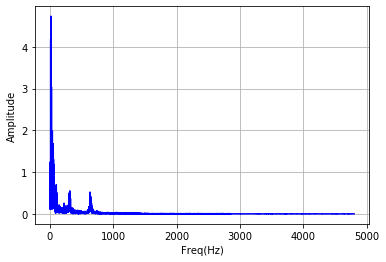

			第31段频域图


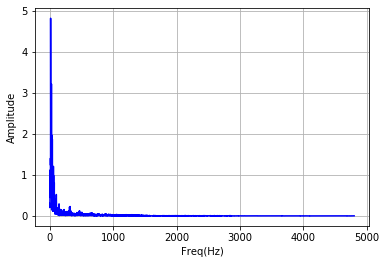

			第32段频域图


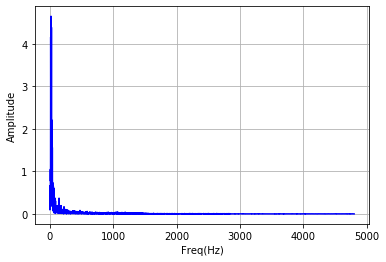

			第33段频域图


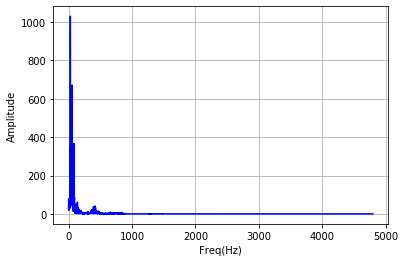

			第34段频域图


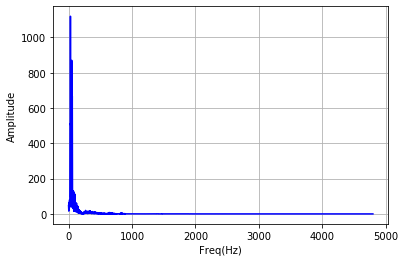

			第35段频域图


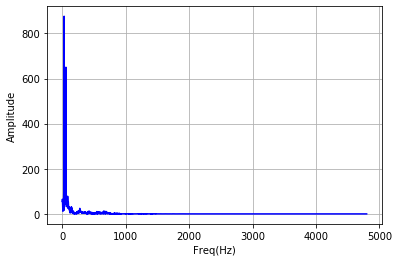

			第36段频域图


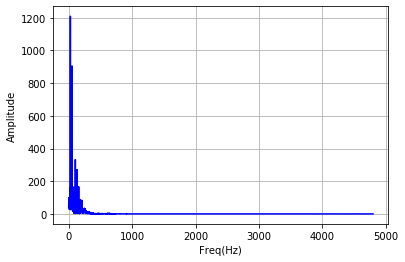

			第37段频域图


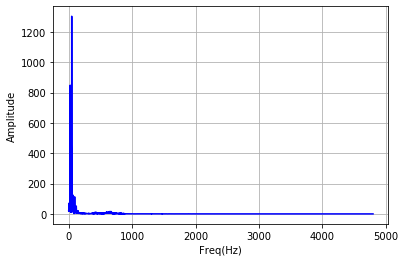

			第38段频域图


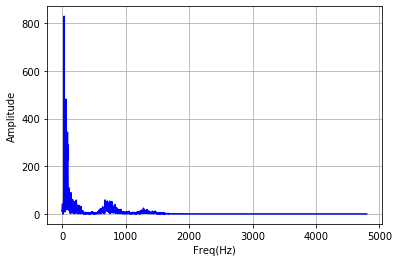

			第39段频域图


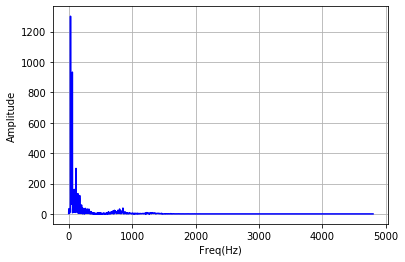

			第40段频域图


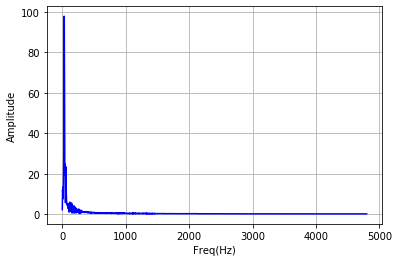

			第41段频域图


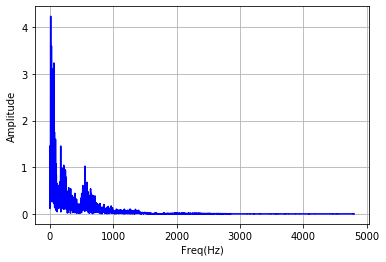

			第42段频域图


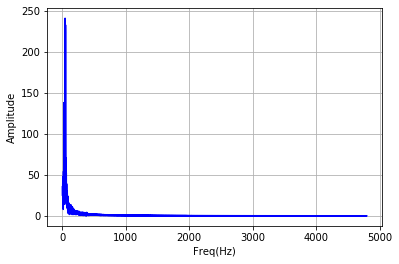

			第43段频域图


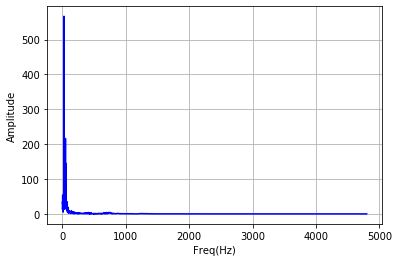

			第44段频域图


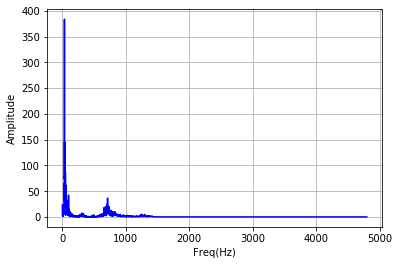

			第45段频域图


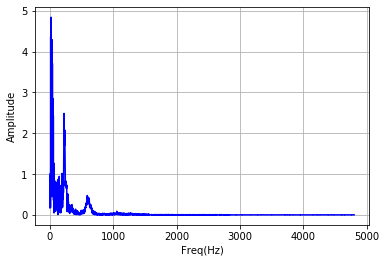

			第46段频域图


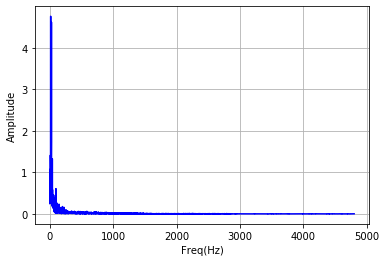

			第47段频域图


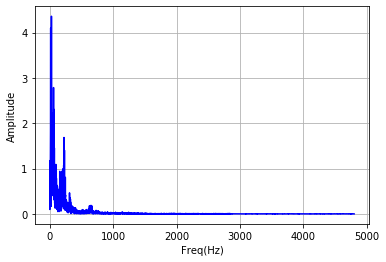

			第48段频域图


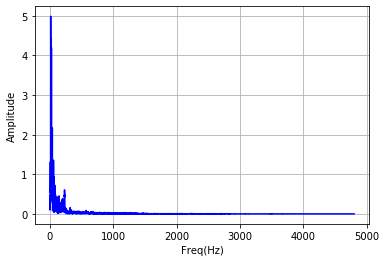

			第49段频域图


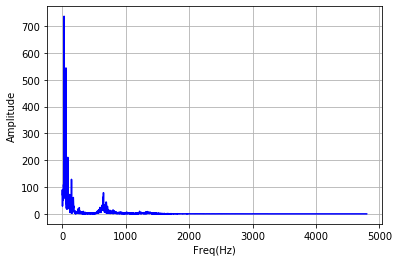

			第50段频域图


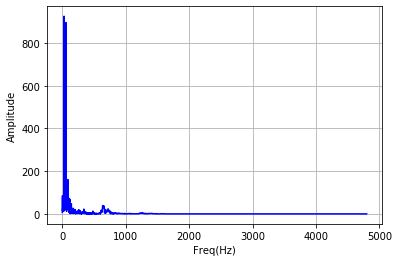

			第51段频域图


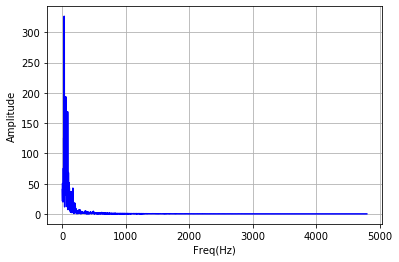

			第52段频域图


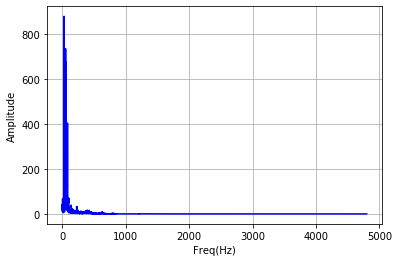

			第53段频域图


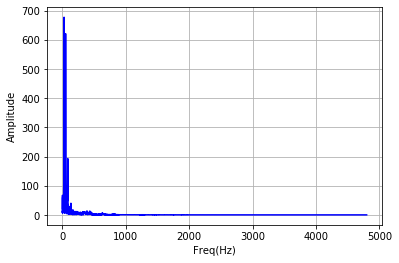

			第54段频域图


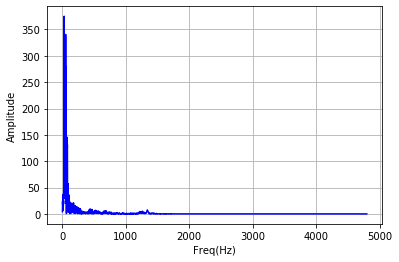

			第55段频域图


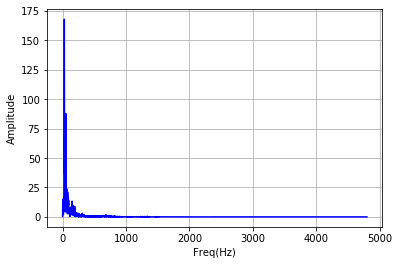

			第56段频域图


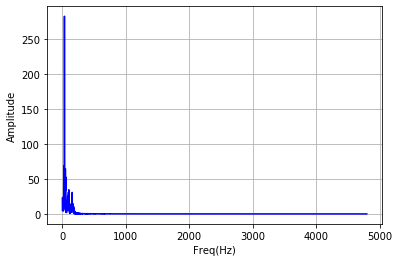

			第57段频域图


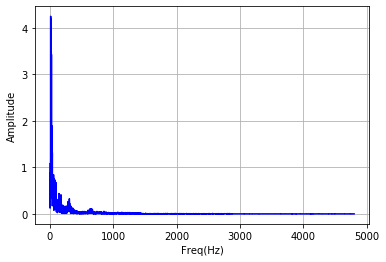

			第58段频域图


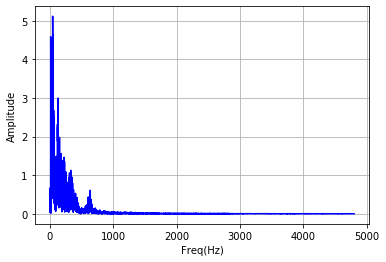

			第59段频域图


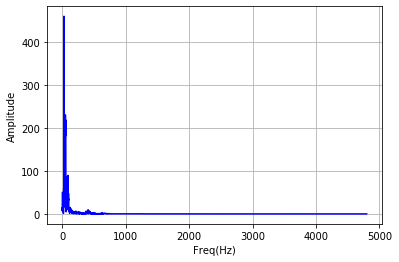

			第60段频域图


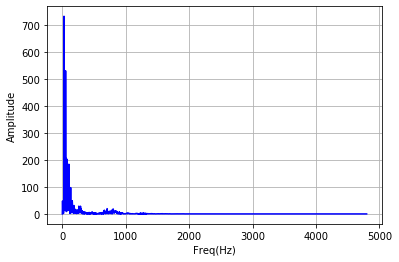

			第61段频域图


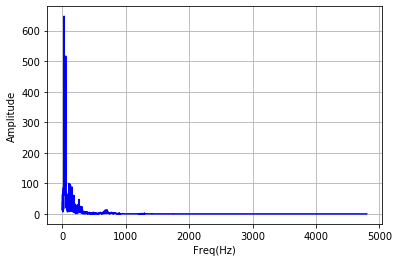

			第62段频域图


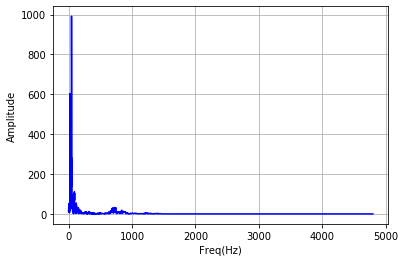

			第63段频域图


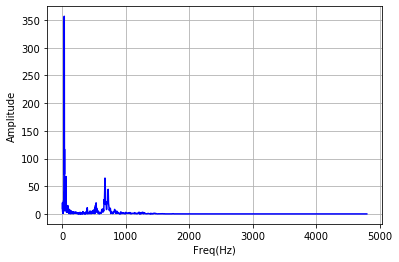

			第64段频域图


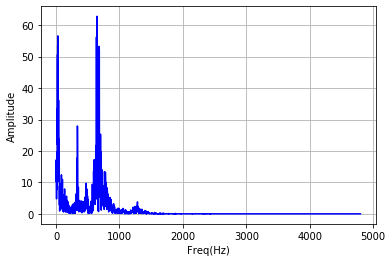

			第65段频域图


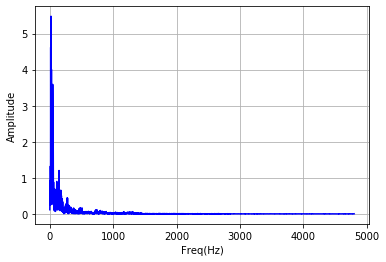

			第66段频域图


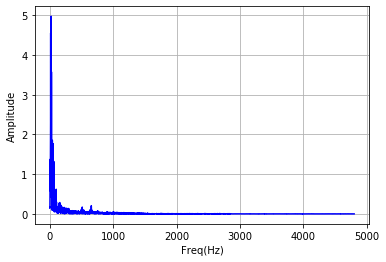

			第67段频域图


In [42]:
#绘制每段的频域图
for i in range(0, len(fft_signal_xmm)):
    Freq(fft_signal_xmm[i])
    print("\t\t\t第{}段频域图".format(i + 1))

# 特征选取

## 取方差最大的前100个特征

In [43]:
#将11人的所有段整合在一起，共有700段，每段4800个特征
feature = np.concatenate([
    fft_signal_fxf, fft_signal_cj, fft_signal_cyy, fft_signal_djj,
    fft_signal_lpy, fft_signal_mf, fft_signal_op, fft_signal_sbb,
    fft_signal_sx, fft_signal_xll, fft_signal_xmm
])
feature_var = np.var(feature, axis=0)  #做方差
feature_var1 = list(feature_var)
feature_var2 = sorted(range(len(feature_var1)),
                      key=lambda k: feature_var1[k],
                      reverse=True)  #降序排列并返回对应的索引值
feature_sort = np.array(feature_var2)[0:100]  #取方差最大的前100个特征
feature_sort.shape

(100,)

In [44]:
#将前100个特征存入新数组中
feature_new = []
for i in range(100):
    feature_new.extend(list(feature[:, feature_sort[i]]))
feature_final = np.array(feature_new).reshape(700, 100)
feature_final.shape

(700, 100)

In [45]:
feature_final

array([[8.75430823e-01, 5.31197181e+02, 3.18305176e+02, ...,
        1.27986485e+02, 2.16638271e+02, 6.05919325e+02],
       [1.37475039e+02, 8.70106315e-01, 4.96410690e-01, ...,
        1.86282118e+00, 1.02098297e+03, 1.88129642e+02],
       [1.99044056e+02, 5.66308979e-01, 9.18188017e-01, ...,
        1.15179673e+02, 8.95107131e+02, 4.39294722e+02],
       ...,
       [6.44473234e+01, 5.44847874e+01, 4.27452783e+00, ...,
        3.95498268e+01, 9.48296546e+01, 7.38097337e+01],
       [1.69636345e+01, 1.27452295e+00, 1.53629256e+00, ...,
        7.35408746e-01, 6.42498229e+01, 4.65603513e+01],
       [4.06712492e-01, 4.74842373e+01, 3.78725645e+01, ...,
        1.64857681e+01, 5.47982287e+00, 3.07640521e+00]])

# 确定训练集与测试集

## 取所有人前3/4段做训练集

In [46]:
fxf_train = int(51 * (3 / 4))
cj_train = int(60 * (3 / 4))
cyy_train = int(68 * (3 / 4))
djj_train = int(41 * (3 / 4))
lpy_train = int(53 * (3 / 4))
mf_train = int(86 * (3 / 4))
op_train = int(79 * (3 / 4))
sbb_train = int(61 * (3 / 4))
sx_train = int(56 * (3 / 4))
xll_train = int(78 * (3 / 4))
xmm_train = int(67 * (3 / 4))

feature_fxf_train = feature_final[:fxf_train]
feature_cj_train = feature_final[51:cj_train + 51]
feature_cyy_train = feature_final[111:cyy_train + 111]
feature_djj_train = feature_final[179:djj_train + 179]
feature_lpy_train = feature_final[220:lpy_train + 220]
feature_mf_train = feature_final[273:mf_train + 273]
feature_op_train = feature_final[359:op_train + 359]
feature_sbb_train = feature_final[438:sbb_train + 438]
feature_sx_train = feature_final[499:sx_train + 499]
feature_xll_train = feature_final[555:xll_train + 555]
feature_xmm_train = feature_final[633:xmm_train + 633]

In [47]:
#最终训练集
Feature_train = np.concatenate([
    feature_fxf_train, feature_cj_train, feature_cyy_train, feature_djj_train,
    feature_lpy_train, feature_mf_train, feature_op_train, feature_sbb_train,
    feature_sx_train, feature_xll_train, feature_xmm_train
])
print("训练集个数：{}".format(len(Feature_train)))
#训练集标签
Label_train = np.concatenate([
    np.ones(fxf_train) * 1,
    np.ones(cj_train) * 2,
    np.ones(cyy_train) * 3,
    np.ones(djj_train) * 4,
    np.ones(lpy_train) * 5,
    np.ones(mf_train) * 6,
    np.ones(op_train) * 7,
    np.ones(sbb_train) * 8,
    np.ones(sx_train) * 9,
    np.ones(xll_train) * 10,
    np.ones(xmm_train) * 11
])
print("标签个数：{}".format(len(Label_train)))

训练集个数：521
标签个数：521


## 取所有人后1/4段做测试集

In [48]:
fxf_test = 51 - fxf_train
cj_test = 60 - cj_train
cyy_test = 68 - cyy_train
djj_test = 41 - djj_train
lpy_test = 53 - lpy_train
mf_test = 86 - mf_train
op_test = 79 - op_train
sbb_test = 61 - sbb_train
sx_test = 56 - sx_train
xll_test = 78 - xll_train
xmm_test = 67 - xmm_train

feature_fxf_test = feature_final[fxf_train:51]
feature_cj_test = feature_final[cj_train + 51:111]
feature_cyy_test = feature_final[cyy_train + 111:179]
feature_djj_test = feature_final[djj_train + 179:220]
feature_lpy_test = feature_final[lpy_train + 220:273]
feature_mf_test = feature_final[mf_train + 273:359]
feature_op_test = feature_final[op_train + 359:438]
feature_sbb_test = feature_final[sbb_train + 438:499]
feature_sx_test = feature_final[sx_train + 499:555]
feature_xll_test = feature_final[xll_train + 555:633]
feature_xmm_test = feature_final[xmm_train + 633:]

In [49]:
#最终训练集
Feature_test = np.concatenate([
    feature_fxf_test, feature_cj_test, feature_cyy_test, feature_djj_test,
    feature_lpy_test, feature_mf_test, feature_op_test, feature_sbb_test,
    feature_sx_test, feature_xll_test, feature_xmm_test
])
print("训练集个数：{}".format(len(Feature_test)))
#训练集标签
Label_test = np.concatenate([
    np.ones(fxf_test) * 1,
    np.ones(cj_test) * 2,
    np.ones(cyy_test) * 3,
    np.ones(djj_test) * 4,
    np.ones(lpy_test) * 5,
    np.ones(mf_test) * 6,
    np.ones(op_test) * 7,
    np.ones(sbb_test) * 8,
    np.ones(sx_test) * 9,
    np.ones(xll_test) * 10,
    np.ones(xmm_test) * 11
])
print("标签个数：{}".format(len(Label_test)))

训练集个数：179
标签个数：179


# 训练模型

## LogisticRegression

In [54]:
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cls.fit(Feature_train, Label_train)
cls.predict(Feature_test)
sco = cls.score(Feature_test, Label_test)
print("该模型预测精度为：{0}".format(sco))

该模型预测精度为：0.21787709497206703


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [51]:
cls.predict(Feature_test)

array([ 3.,  3.,  1.,  2., 10.,  9.,  1., 11.,  1.,  1.,  2.,  3.,  1.,
        2.,  3.,  1.,  4.,  7., 11.,  7.,  3.,  2.,  2.,  5.,  2.,  2.,
        2.,  2., 11.,  4., 11.,  8.,  3., 11.,  9.,  4.,  4.,  9., 11.,
        3., 10.,  3.,  4.,  3.,  7.,  7.,  5.,  3.,  5.,  5.,  5.,  5.,
        5.,  5.,  3.,  5.,  6.,  4.,  4.,  4., 11.,  6.,  7.,  6.,  6.,
        6.,  1.,  4.,  1., 11., 10.,  1.,  5.,  5.,  5.,  7.,  7.,  9.,
        7.,  7.,  7.,  7., 10.,  8.,  3.,  2.,  8.,  6.,  6.,  6.,  7.,
        7.,  7.,  2.,  8.,  9.,  9., 10.,  6.,  7., 10.,  7.,  5.,  9.,
        7.,  2.,  7.,  7.,  8.,  8.,  7.,  8.,  8.,  3.,  8., 10., 11.,
        8.,  7.,  9.,  9.,  9., 10.,  8.,  9., 10., 10., 10.,  9., 10.,
        8., 10.,  9., 10., 10.,  8., 11.,  6., 10.,  7., 11.,  9.,  7.,
       11.,  2.,  1.,  9.,  4.,  2., 11.,  5., 10.,  9., 10., 10.,  9.,
        9.,  4., 11., 10., 10.,  8., 11.,  2.,  9.,  1.,  4.,  3.,  4.,
        6.,  9.,  2.,  1.,  9., 10.,  1.,  2.,  2., 10.])

## SVM

In [52]:
from sklearn.svm import LinearSVC  #线性支持向量分类器
linear_svm = LinearSVC()
linear_svm.fit(Feature_train, Label_train)
linear_svm.predict(Feature_test)
sco2 = linear_svm.score(Feature_test, Label_test)
print("该模型预测精度为：{0}".format(sco2))

该模型预测精度为：0.18435754189944134


D:\anaconda\Lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [53]:
linear_svm.predict(Feature_test)

array([ 3.,  2.,  6.,  1.,  1.,  9.,  1., 11.,  1.,  1.,  2.,  4.,  6.,
        3.,  6.,  1.,  4., 10.,  9.,  6.,  9.,  9.,  2.,  5.,  2.,  2.,
       11., 11., 11., 10., 11.,  8.,  6.,  8.,  9.,  4.,  4.,  9., 11.,
       10., 10.,  7., 10.,  3.,  6.,  7.,  5.,  5.,  5.,  5.,  5.,  1.,
        5.,  5.,  3.,  5.,  6.,  4.,  5.,  4.,  4.,  6.,  7.,  4.,  6.,
        6., 10., 11.,  1., 11., 10.,  1.,  6.,  5.,  5.,  7.,  8.,  9.,
        7.,  7.,  5.,  7.,  8.,  8.,  4.,  1.,  8.,  6., 10.,  3.,  7.,
        9.,  9.,  2.,  8.,  9.,  9.,  8., 10.,  7.,  4.,  2.,  5.,  9.,
        7.,  9.,  7.,  5.,  8.,  8.,  7.,  8.,  8.,  8.,  8., 11.,  9.,
        9.,  6.,  9.,  9.,  9., 11., 10.,  9., 10., 10., 10.,  9.,  8.,
       10.,  9., 11., 10.,  9., 11., 10.,  6., 10.,  7.,  2.,  9.,  7.,
       10.,  2.,  1.,  8., 10.,  2., 11.,  4.,  9., 10., 10., 10.,  5.,
        7., 10.,  8., 10., 10.,  8., 11.,  2., 10.,  1.,  4.,  3.,  4.,
        6.,  7.,  2.,  1.,  7., 10.,  2., 11.,  9.,  8.])